In [ ]:
Source: https://github.com/Tommylee1013/QUANTIFI

In [1]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, DateFormatter
import matplotlib.finance as mpf
import decimal
import datetime

from data_handler import data_handler

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
tickers = ['WMT', 'XOM', 'FB']
start_date = '2006-02-12'
end_date = '2016-02-12'

# Based off of Part 00
raw_data = data_handler.main(tickers, start_date, end_date)
data = {}

for ticker in raw_data.keys():
    data[ticker] = []
    for row in sorted(raw_data[ticker], key=lambda x: datetime.datetime.strptime(x['Date'], '%Y-%m-%d')):
        data[ticker].append([datetime.datetime.strptime(row['Date'], '%Y-%m-%d').date(), float(row['Adj_Close'])])


Found in cache!!!
Found in cache!!!
Found in cache!!!


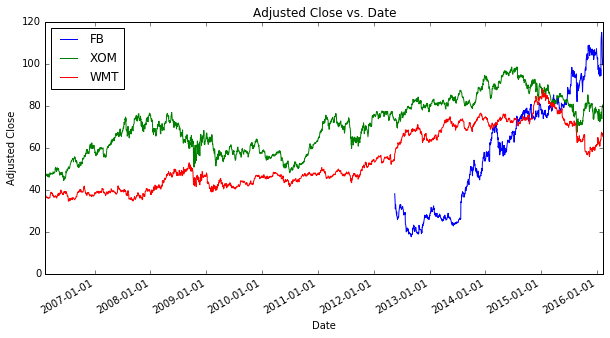

In [3]:
# Let's plot Adjusted Close vs. Date
colors = ['b', 'g', 'r', 'y']
labels = []
cnt = 0
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
handles = []
for ticker, points in data.items():
    t = [i[0] for i in points]
    adj_close = [i[1] for i in points]
    temp, = ax.plot(t, adj_close, color=colors[cnt%len(colors)], label=ticker)
    handles.append(temp)
    cnt += 1

ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))

ax.set_title('Adjusted Close vs. Date')
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted Close')
try:
    ax.legend(handles=handles, loc='best')
except:
    ax.legend(handles=handles, loc='right')
fig.autofmt_xdate()

plt.show()

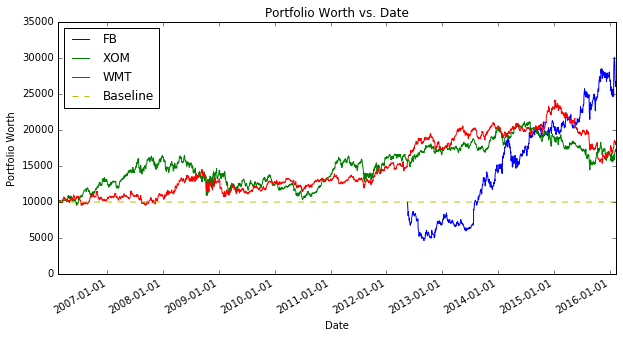

In [4]:
# What happens if we invest $x in a stock at the start date?
wealth = 10000
colors = ['b', 'g', 'r', 'y']
labels = []
cnt = 0
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
handles = []
t = []
for ticker, points in data.items():
    t = [i[0] for i in points]
    shares = wealth/points[0][1]
    adj_close = [shares*i[1] for i in points]
    temp, = ax.plot(t, adj_close, color=colors[cnt%len(colors)], label=ticker)
    handles.append(temp)
    cnt += 1

temp, = ax.plot(t, [wealth for _ in range(len(t))], '--', color=colors[cnt%len(colors)], label='Baseline')
handles.append(temp)
ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))

ax.set_title('Portfolio Worth vs. Date')
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Worth')
try:
    ax.legend(handles=handles, loc='best')
except:
    ax.legend(handles=handles, loc='left')
fig.autofmt_xdate()

plt.show()

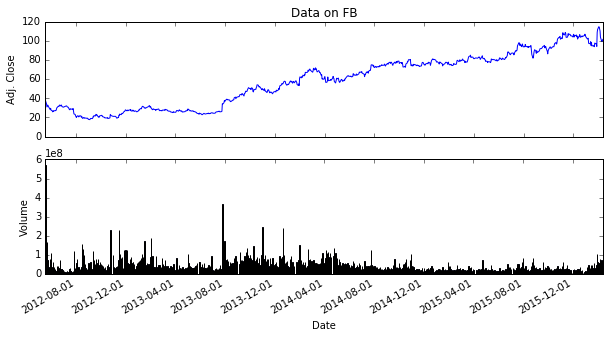

In [5]:
ticker = 'FB'
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(2, 1, 1)
ax1.set_title('Data on %s'%ticker)

ax2 = fig.add_subplot(2, 1, 2)

dates = []
adj_close = []
volumes = []
for row in sorted(raw_data[ticker], key=lambda x: datetime.datetime.strptime(x['Date'], '%Y-%m-%d')):
    dates.append(datetime.datetime.strptime(row['Date'], '%Y-%m-%d').date())
    adj_close.append(float(row['Adj_Close']))
    volumes.append(int(row['Volume']))
ax1.plot(dates, adj_close)
ax1.set_ylabel('Adj. Close')

ax2.bar(dates, volumes)
ax2.xaxis.set_major_locator(AutoDateLocator())
ax2.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax2.set_xlabel('Date')
ax2.set_ylabel('Volume')
fig.autofmt_xdate()

plt.show()

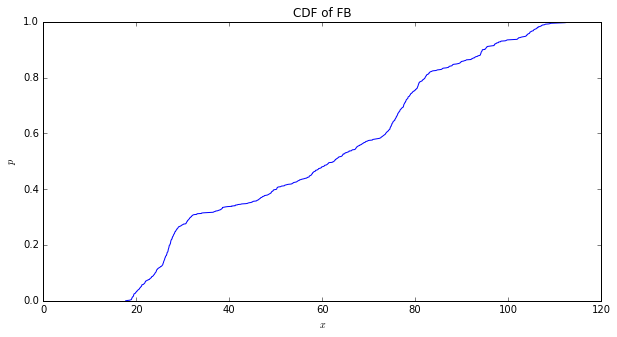

In [6]:
# What about the CDF?
import numpy as np
fb_adj_close = np.sort(np.array(adj_close))
p = 1. * np.arange(len(fb_adj_close))/(len(fb_adj_close)-1)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(fb_adj_close, p)
ax.set_ylabel('$p$')
ax.set_xlabel('$x$')
ax.set_title('CDF of FB')
plt.show()
